# Informatyka w Medycynie - Zadanie 1 - Tomograf

Autorzy: Sławomir Gilewski, Dariusz Max Adamski

In [137]:
%matplotlib inline

In [138]:
import datetime
import os

from math import degrees, radians
from pprint import pprint

from multiprocessing import Pool
from functools import partial

import numpy as np
import pydicom

from skimage.io import imread
from skimage.data import shepp_logan_phantom
from skimage.draw import circle, line
from skimage.color import gray2rgb, rgb2gray

from scipy.fftpack import fft, ifft, fftfreq

import matplotlib.pyplot as plt

Funkcje pomocnicze

In [139]:
def center_pad(array, shape, *args, **kwargs):
    """Wycentrowany padding do danego rozmiaru"""
    pad = (np.array(shape) - np.array(array.shape)) / 2
    pad = np.array([np.floor(pad), np.ceil(pad)]).T.astype(int)
    return np.pad(array, pad, *args, **kwargs)

def circle_pad(array, *args, **kwargs):
    """Wycentrowany padding do boku równego średnicy okręgu opisanego na prostokącie"""
    w, h = array.shape
    side = int(np.ceil(np.sqrt(w**2 + h**2)))
    return center_pad(array, (side, side), *args, **kwargs)

def center_of(array):
    """Center indices of an n-dimensional array"""
    return np.floor(np.array(array.shape) / 2).astype(int)

def rescale(array, min=0, max=1):
    """Rescale array elements to range [min, max]"""
    res = array.astype('float32')
    res -= np.min(res)
    res /= np.max(res)
    res -= min
    res *= max
    return res

def clip(array, min, max):
    """Clip array elements to range [min, max]"""
    array[array < min] = min
    array[array > max] = max
    return array

def rmse(a, b):
    """Root mean square error"""
    a, b = rescale(a), rescale(b)
    return np.sqrt(np.mean((a - b)**2))

def cut_pad(img, height, width):
    y,x = img.shape
    startx = x//2-(width//2)
    starty = y//2-(height//2)    
    return img[starty:starty+height,startx:startx+width]

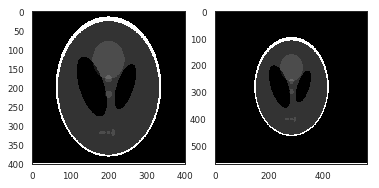

In [140]:
input_image = shepp_logan_phantom()
pad_image = circle_pad(input_image)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(input_image, cmap='gray')
ax2.imshow(pad_image, cmap='gray')

Functions to calculate emiter and detector coordinates:

In [141]:
def circle_points(angle_shift, angle_range, count, radius=1, center=(0, 0)):
    angles = np.linspace(0, angle_range, count) + angle_shift
    cx, cy = center
    x = radius * np.cos(angles) - cx
    y = radius * np.sin(angles) - cy
    points = np.array(list(zip(x, y)))
    return np.floor(points).astype(int)

def detector_coords(alpha, angle_range, count, radius=1, center=(0,0)):
    return circle_points(radians(alpha - angle_range/2), radians(angle_range), count, radius, center)

def emitter_coords(alpha, angle_range, count, radius=1, center=(0,0)):
    return circle_points(radians(alpha - angle_range/2 + 180), radians(angle_range), count, radius, center)[::-1]

Bresenham line function (https://github.com/marcotama/bresenham/blob/vectorized_implementation/bresenham_numpy.py)

In [142]:
def bresenham(x0, y0, x1, y1):
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else 1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)
    if swapped:
        xs, ys = ys, xs
    return np.array([xs, ys])

def radon_lines(emitters, detectors):
    return [np.array(bresenham(x0, y0, x1, y1)) for (x0, y0), (x1, y1) in zip(emitters, detectors)]

Demonstrating the points calculated by the functions:

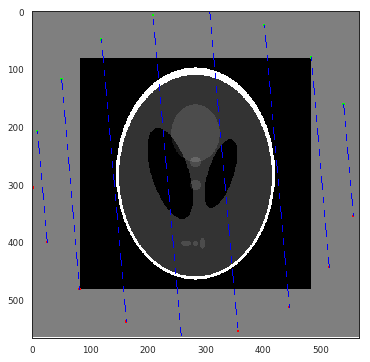

In [143]:
def draw_tomography(image):
    image = circle_pad(image, constant_values=0.5)
    radius, center = image.shape[0]//2, center_of(image)
    fig, ax = plt.subplots(1, figsize=(6, 6))
    def do(alpha=0, detectors=50, angle_range=90):
        emitters = emitter_coords(alpha, angle_range, detectors, radius, center)
        detectors = detector_coords(alpha, angle_range, detectors, radius, center)
        lines = radon_lines(emitters, detectors)
        img = gray2rgb(image)
        for x, y in emitters:
            img[x-2:x+2,y-2:y+2] = (0,1,0)
        for x, y in detectors:
            img[x-2:x+2,y-2:y+2] = (1,0,0)
        for line in lines:
            img[tuple(line)] = (0,0,1)
        ax.imshow(img, aspect=1, interpolation='none')
    return do

#%matplotlib notebook
#widgets.interact(draw_tomography(image), alpha=(0,360,10), detectors=(0,100,5), angle_range=(45,270,5))
%matplotlib inline
draw_tomography(input_image)(alpha=5, angle_range=180, detectors=10)

Function that returns points that form a line for every emiter-detector pair:

In [144]:
def single_radon_transform(detector_count, angle_range, image, radius, center, alpha):
    emitters = emitter_coords(alpha, angle_range, detector_count, radius, center)
    detectors = detector_coords(alpha, angle_range, detector_count, radius, center)
    lines = radon_lines(emitters, detectors)
    result = rescale(np.array([np.sum(image[tuple(line)]) for line in lines]))
    return result

def radon_transform(image, scan_count, detector_count, angle_range, pad=True, plot=False):
    if pad: image = circle_pad(image)
    center = center_of(image)
    width = height = image.shape[0]
    radius = width // 2
    alphas = np.linspace(0, 180, scan_count)
    results = np.zeros((scan_count, detector_count))
    if plot:
        plt.figure()
        for i, alpha in enumerate(alphas):
            results[i] = single_radon_transform(detector_count, angle_range, image, radius, center, alpha)
            plt.imshow(np.swapaxes(results,0,1), cmap=plt.cm.Greys_r)
            plt.show()
            clear_output(wait=True)
    else:
        # ~core times faster
        with Pool() as pool:
            results = pool.map(partial(single_radon_transform, detector_count, angle_range, image, radius, center), alphas)
        
    return np.swapaxes(results,0,1)

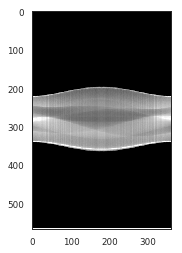

In [145]:
number_of_scans = 360
number_of_detectors = pad_image.shape[0]
angle_range = 270
sinogram = radon_transform(input_image, number_of_scans, number_of_detectors, angle_range, plot=False)
plt.imshow(sinogram, cmap='gray')

Inverse radon transform (backprojection) with optional filtering :

In [146]:
def filter_sinogram(sinogram):
    n = sinogram.shape[0] # number of detectors
    filter = 2 * np.abs(fftfreq(n).reshape(-1, 1))
    result = ifft(fft(sinogram, axis=0) * filter, axis=0)
    result = clip(np.real(result), 0, 1)
    return result
    
def single_inverse_radon_transform(image, tmp, single_alpha_sinogram, alpha, detector_count, angle_range, radius, center):
    emitters = emitter_coords(alpha, angle_range, detector_count, radius, center)
    detectors = detector_coords(alpha, angle_range, detector_count, radius, center)
    lines = radon_lines(emitters, detectors)
    for i, line in enumerate(lines):
        image[tuple(line)] += single_alpha_sinogram[i]
        tmp[tuple(line)] += 1

def inverse_radon(shape, sinogram, angle_range, pad=True, plot=False, filtering=False):
    if filtering:
        sinogram = filter_sinogram(sinogram)
    number_of_detectors, number_of_scans = sinogram.shape
    sinogram = np.swapaxes(sinogram,0,1)
    
    result = np.zeros(shape)
    if pad: result = circle_pad(result)
    tmp = np.zeros(result.shape)
    
    center = center_of(result)
    width = height = result.shape[0]
    radius = width // 2
    alphas = np.linspace(0, 180, number_of_scans)
    
    for i, alpha in enumerate(alphas):
        single_inverse_radon_transform(result, tmp, sinogram[i], alpha, number_of_detectors, angle_range, radius, center)
        if plot:
            plt.imshow(result, cmap=plt.cm.Greys_r)
            plt.show()
            clear_output(wait=True)
    
    tmp[tmp == 0] = 1
    result = rescale(result / tmp)
    if pad: result = cut_pad(result, *shape)
    return result

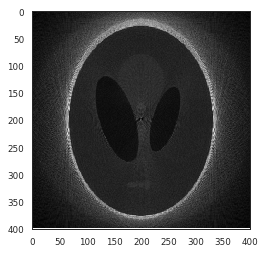

In [147]:
output = inverse_radon(input_image.shape, sinogram, angle_range, plot=False, filtering=True)
plt.imshow(output, cmap="gray")

## Obsługa plików DICOM

In [148]:
def read_dicom(path):
    from pydicom import dcmread
    ds = dcmread(path)
    # assume dicom metadata identifiers are uppercase
    keys = {x for x in dir(ds) if x[0].isupper()} - {'PixelData'}
    meta = {x: getattr(ds, x) for x in keys}
    image = ds.pixel_array
    return image, meta

def write_dicom(path, image, meta):
    from pydicom.dataset import Dataset, FileDataset, validate_file_meta
    from pydicom.uid import generate_uid
    from pydicom._storage_sopclass_uids import MRImageStorage
    
    ds = Dataset()
    ds.MediaStorageSOPClassUID = MRImageStorage
    ds.MediaStorageSOPInstanceUID = generate_uid()
    ds.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    fd = FileDataset(path, {}, file_meta=ds, preamble=b'\0'*128)
    fd.is_little_endian = True
    fd.is_implicit_VR = False
    
    fd.SOPClassUID = MRImageStorage
    fd.PatientName = 'Test^Firstname'
    fd.PatientID = '123456'
    now = datetime.datetime.now()
    fd.StudyDate = now.strftime('%Y%m%d')

    fd.Modality = 'MR'
    fd.SeriesInstanceUID = generate_uid()
    fd.StudyInstanceUID = generate_uid()
    fd.FrameOfReferenceUID = generate_uid()
    
    fd.BitsStored = 16
    fd.BitsAllocated = 16
    fd.SamplesPerPixel = 1
    fd.HighBit = 15
    
    fd.ImagesInAcquisition = '1'
    fd.Rows = image.shape[0]
    fd.Columns = image.shape[1]
    fd.InstanceNumber = 1
    
    fd.ImagePositionPatient = r'0\0\1'
    fd.ImageOrientationPatient = r'1\0\0\0\-1\0'
    fd.ImageType = r'ORIGINAL\PRIMARY\AXIAL'
    
    fd.RescaleIntercept = '0'
    fd.RescaleSlope = '1'
    fd.PixelSpacing = r'1\1'
    fd.PhotometricInterpretation = 'MONOCHROME2'
    fd.PixelRepresentation = 1
    
    for key, value in meta.items():
        setattr(fd, key, value)
    
    validate_file_meta(fd.file_meta, enforce_standard=True)
    
    fd.PixelData = (image*255).astype(np.uint16).tobytes()
    fd.save_as(path)

In [149]:
# sprawdzone w https://www.imaios.com/en/Imaios-Dicom-Viewer
write_dicom('test.dcm', input_image, dict(
    PatientName='Doe^John',
    PatientID='666',
    ImageComments='No comment :)',
    StudyDate='20200213',
))

{'BitsAllocated': 16,
 'BitsStored': 16,
 'Columns': 400,
 'FrameOfReferenceUID': '1.2.826.0.1.3680043.8.498.29892092822235752669219929917715570188',
 'HighBit': 15,
 'ImageComments': 'No comment :)',
 'ImageOrientationPatient': [1, 0, 0, 0, -1, 0],
 'ImagePositionPatient': [0, 0, 1],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'AXIAL'],
 'ImagesInAcquisition': "1",
 'InstanceNumber': "1",
 'Modality': 'MR',
 'PatientID': '666',
 'PatientName': 'Doe^John',
 'PhotometricInterpretation': 'MONOCHROME2',
 'PixelRepresentation': 1,
 'PixelSpacing': [1, 1],
 'RescaleIntercept': "0.0",
 'RescaleSlope': "1.0",
 'Rows': 400,
 'SOPClassUID': '1.2.840.10008.5.1.4.1.1.4',
 'SamplesPerPixel': 1,
 'SeriesInstanceUID': '1.2.826.0.1.3680043.8.498.10313210512943825431355276143807626305',
 'StudyDate': '20200213',
 'StudyInstanceUID': '1.2.826.0.1.3680043.8.498.84398616927080404111860474553373761665'}


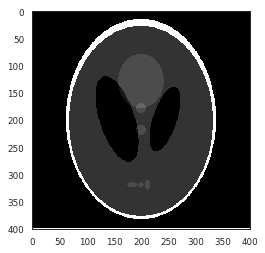

In [150]:
image, meta = read_dicom('test.dcm')
plt.imshow(image, cmap='gray')
pprint(meta)

## Analiza statystyczna

In [151]:
def test(image, scans, detectors, angle_range, filtering, plot=False):
    padded = circle_pad(image)
    sinogram = radon_transform(padded, scans, detectors, angle_range, pad=False)
    output = inverse_radon(padded.shape, sinogram, angle_range, filtering=filtering, pad=False)
    output = cut_pad(output, *image.shape)
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(10,10))
        axs[0].imshow(image, cmap='gray')
        axs[1].imshow(output, cmap='gray')
    return output, rmse(image, output)

def test_filtering(image, scans=360, detectors=360, angle=270):
    y1, loss1 = test(image, scans, detectors, angle, filtering=False)
    y2, loss2 = test(image, scans, detectors, angle, filtering=True)
    print(f'rmse no filtering  {loss1:.6f}')
    print(f'rmse filtering     {loss2:.6f}')
    fig, axs = plt.subplots(1, 3, figsize=(10,10))
    axs[0].imshow(image, cmap='gray')
    axs[1].imshow(y1, cmap='gray')
    axs[2].imshow(y2, cmap='gray')

rmse 0.182613


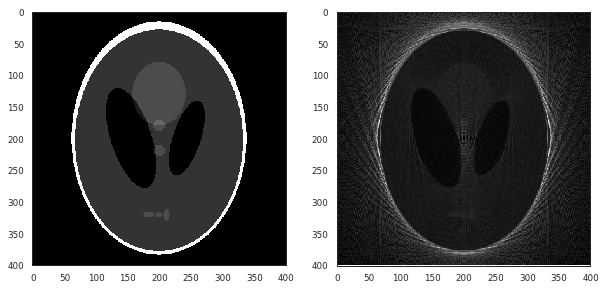

In [114]:
output, loss = test(shepp_logan_phantom(), 180, 180, 180, True, plot=True)
print(f'rmse {loss:.6f}')

### Eksperymenty

In [153]:
img = rgb2gray(imread('tomograf-zdjecia/SADDLE_PE.JPG'))

In [109]:
scans = np.arange(90, 720+1, 90)
rmse1 = [test(img, x, 180, 180, False)[1] for x in scans]
np.vstack([scans, rmse1]).T

array([[9.00000000e+01, 3.78408492e-01],
       [1.80000000e+02, 3.85319471e-01],
       [2.70000000e+02, 3.72724652e-01],
       [3.60000000e+02, 3.91266972e-01],
       [4.50000000e+02, 3.91803503e-01],
       [5.40000000e+02, 3.90623391e-01],
       [6.30000000e+02, 3.80940288e-01],
       [7.20000000e+02, 3.92906547e-01]])

In [110]:
detec = np.arange(90, 720+1, 90)
rmse2 = [test(img, 180, x, 180, False)[1] for x in detec]
np.vstack([scans, rmse2]).T

array([[9.00000000e+01, 3.83043617e-01],
       [1.80000000e+02, 3.85319471e-01],
       [2.70000000e+02, 3.90757203e-01],
       [3.60000000e+02, 4.01918322e-01],
       [4.50000000e+02, 4.03907150e-01],
       [5.40000000e+02, 4.01951551e-01],
       [6.30000000e+02, 4.12528515e-01],
       [7.20000000e+02, 4.14617896e-01]])

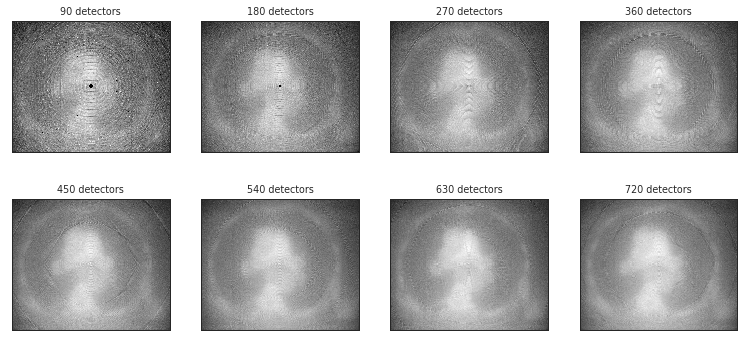

In [132]:
imgs = [test(img, 180, x, 180, False)[0] for x in detec]
fig, axs = plt.subplots(2, 4, figsize=(13, 6))
axs = np.array(axs).reshape(-1)
for i, x in enumerate(detec):
    axs[i].imshow(imgs[i], cmap='gray')
    axs[i].set_xticks([]); axs[i].set_yticks([])
    axs[i].set_title(f'{x} detectors')

In [133]:
imgs = [test(img, 180, 180, x, False)[0] for x in angle]

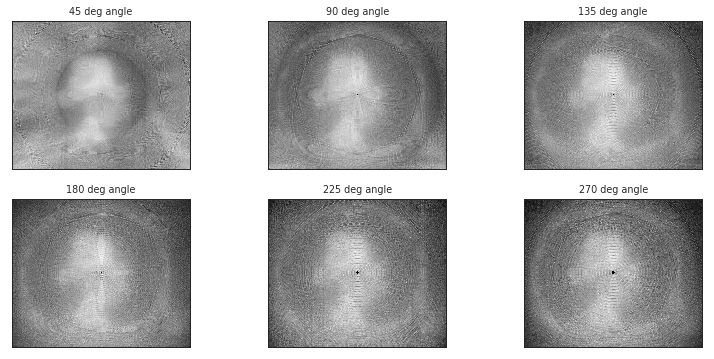

In [136]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))
axs = np.array(axs).reshape(-1)
for i, x in enumerate(angle):
    axs[i].imshow(imgs[i], cmap='gray')
    axs[i].set_xticks([]); axs[i].set_yticks([])
    axs[i].set_title(f'{x} deg angle')

In [111]:
angle = np.arange(45, 270+1, 45)
rmse3 = [test(img, 180, 180, x, False)[1] for x in angle]
np.vstack([angle, rmse3]).T

array([[ 45.        ,   0.4377794 ],
       [ 90.        ,   0.37809744],
       [135.        ,   0.39318833],
       [180.        ,   0.38531947],
       [225.        ,   0.3827374 ],
       [270.        ,   0.37499222]])

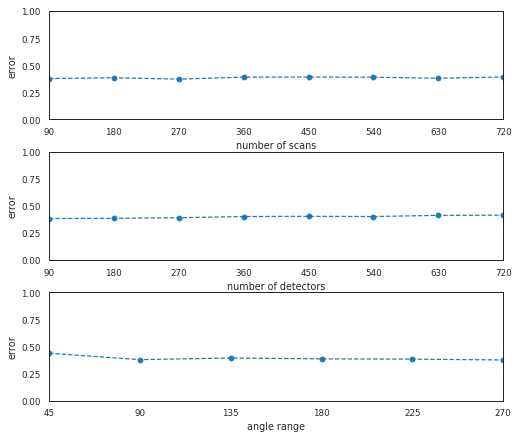

In [112]:
def plot_axis(ax, xs, ys, xlabel='', ylabel=''):
    ax.plot(xs, ys, marker='o', linestyle='--')
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel) 
    ax.set_xlim(np.min(xs), np.max(xs)); ax.set_ylim(0, 1)
    ax.set_xticks(xs); ax.set_yticks(np.linspace(0, 1, 5))
    
import seaborn as sns
sns.set_style('white')
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex=False, figsize=(7, 6))
fig.tight_layout()
plot_axis(ax1, scans, rmse1, xlabel='number of scans', ylabel='error')
plot_axis(ax2, detec, rmse2, xlabel='number of detectors', ylabel='error')
plot_axis(ax3, angle, rmse3, xlabel='angle range', ylabel='error')
plt.show()

rmse no filtering  0.365851
rmse filtering     0.371541


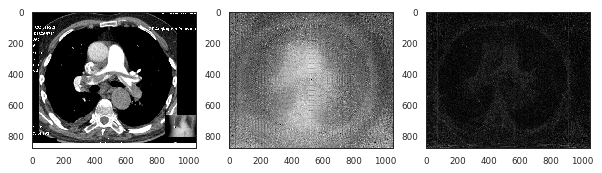

In [113]:
test_filtering(img, scans=100, detectors=100, angle=90)

rmse no filtering  0.482961
rmse filtering     0.195934


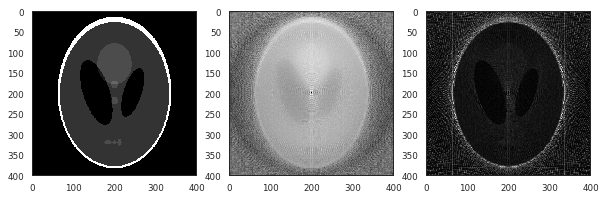

In [115]:
test_filtering(shepp_logan_phantom(), scans=100, detectors=100, angle=90)